In [1]:
import numpy as np
import vtk
import matplotlib
import matplotlib.pyplot as plt

from common.model import MyModel
from common.dataset import MyDataset
from common.utils import uncubify, slice_cuboid, pad_3d, get_all_gen_items

Using TensorFlow backend.


In [2]:
w = 192
h = 256
d = 256

cube_dim = 256

In [3]:
# 3D Model for brain

# setup = {
#     'struct': 'brain', 'arch': 'Unet', 'loss_fn': 'binary',
#     'batch_size': 4, 'filters': 16, 'batch_norm': True,
#     'optimizer_fn': 'RAdam', 'threshold': 0.5,
#     'filename': 'brain_Unet_RAdam_binary_bs-32_bn-True_f-16',
#     'input_shape': (192, 256, 1)
# }

# collection_name = 'mindboggle_84_Nx192x256_brain'

In [4]:
# 3D Model for lateral ventricle

setup = {
    'struct': 'lateral_ventricle', 'arch': 'Unet', 'loss_fn': 'binary',
    'batch_size': 4, 'filters': 16, 'batch_norm': True,
    'optimizer_fn': 'Adam', 'threshold': 0.5,
    'filename': 'lateral_ventricle_Unet_Adam_binary_bs-32_bn-True_f-16',
    'input_shape': (192, 256, 1)
}

collection_name = 'mindboggle_84_Nx192x256_lateral_ventricle'

# Create generators

In [5]:
my_dataset = MyDataset(
    collection_name = collection_name,
    batch_size = setup['batch_size'],
    input_shape = (192, 256, 1)
)

In [6]:
train_generator, valid_generator, test_generator = my_dataset.get_generators()

# Load model

In [7]:
my_model = MyModel(
    train_generator = train_generator,
    valid_generator = valid_generator,
    test_generator = test_generator,
    struct = setup['struct'],
    arch = setup['arch'],
    loss_fn = setup['loss_fn'],
    optimizer_fn = setup['optimizer_fn'],
    batch_size = setup['batch_size'],
    batch_norm = setup['batch_norm'],
    filters = setup['filters'],
    input_shape = setup['input_shape']
)

In [8]:
# It is possible to pass custom filename
#  otherwise model file will be constructed automaticaly
my_model.create(load_weights=True, filename=setup['filename'])
my_model.print_summary()

W0913 13:14:22.371020 139700276832064 deprecation_wrapper.py:119] From /home/filip/.conda/envs/ml-sandbox/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 13:14:22.371583 139700276832064 deprecation_wrapper.py:119] From /home/filip/.conda/envs/ml-sandbox/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 13:14:22.373334 139700276832064 deprecation_wrapper.py:119] From /home/filip/.conda/envs/ml-sandbox/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 13:14:22.389473 139700276832064 deprecation_wrapper.py:119] From /home/filip/.conda/envs/ml-sandbox/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is de

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Predict structure

In [9]:
preds = my_model.predict(test_generator, setup['threshold'])
preds

64/64 [==============================] - 13s 203ms/step


array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [10]:
preds = np.moveaxis(preds.squeeze(), 0, 1)
preds.shape

(192, 256, 256)

### Cubify scan image

In [11]:
pred_scan = pad_3d(preds, w, h, d, cube_dim)
pred_scan.shape

(256, 256, 256)

# Plot in 2d

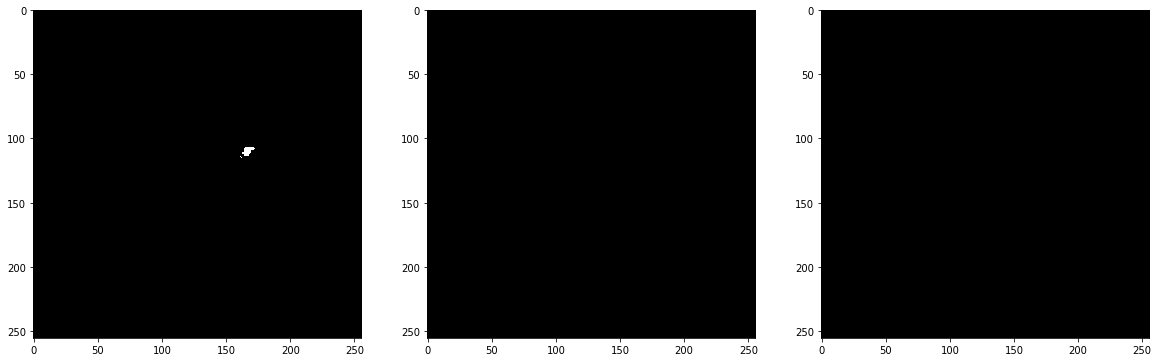

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

im1 = pred_scan[100, :, :]
im2 = pred_scan[:, 100, :]
im3 = pred_scan[:, :, 100]

ax1.imshow(im1, cmap='gray')
ax2.imshow(im2, cmap='gray')
ax3.imshow(im3, cmap='gray')

# Plot in 2d with confusions

In [13]:
_, test_scan = get_all_gen_items(test_generator)
test_scan.shape

(256, 192, 256, 1)

In [14]:
test_scan = np.moveaxis(test_scan.squeeze(), 0, 1)
test_scan.shape

(192, 256, 256)

In [15]:
test_scan = pad_3d(test_scan, w, d, h, cube_dim)
test_scan.shape

(256, 256, 256)

### Calculate confusions

In [16]:
conf_scan = (test_scan * 2 + pred_scan).astype(np.uint8)
conf_scan.shape

(256, 256, 256)

In [17]:
cmap = matplotlib.colors.ListedColormap(['black', 'red', 'yellow', 'green'])
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)

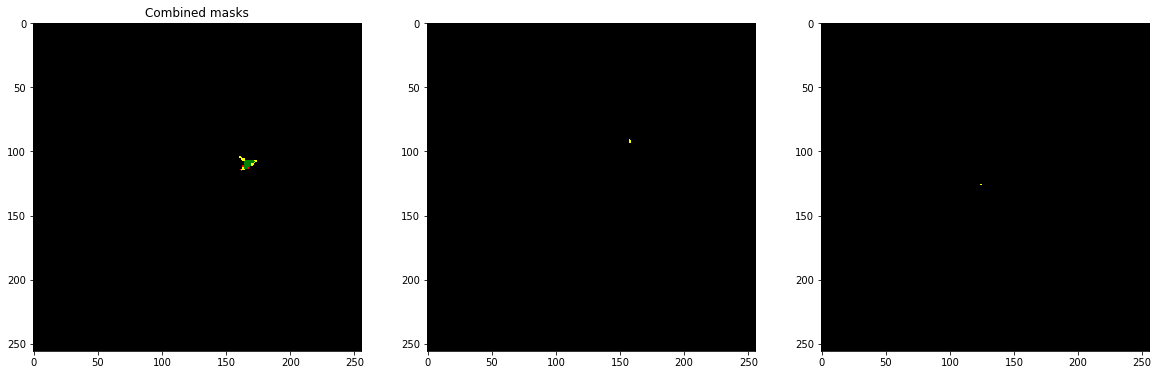

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

combined_0 = conf_scan[100, :, :]
combined_1 = conf_scan[:, 100, :]
combined_2 = conf_scan[:, :, 100]

ax1.set_title('Combined masks')
ax1.imshow(combined_0, cmap=cmap, norm=norm)
ax2.imshow(combined_1, cmap=cmap, norm=norm)
ax3.imshow(combined_2, cmap=cmap, norm=norm)

# Define rendering function

In [19]:
def render_scan(scan, dim):
    colors = vtk.vtkNamedColors()

    # We begin by creating the data we want to render.
    # For this tutorial, we create a 3D-image containing three overlaping cubes.
    # This data can of course easily be replaced by data from a medical CT-scan or anything else three dimensional.
    # The only limit is that the data must be reduced to unsigned 8 bit or 16 bit integers.
    data_matrix = scan

    # For VTK to be able to use the data, it must be stored as a VTK-image.
    #  This can be done by the vtkImageImport-class which
    # imports raw data and stores it.
    dataImporter = vtk.vtkImageImport()
    # The previously created array is converted to a string of chars and imported.
    data_string = data_matrix.tostring()
    dataImporter.CopyImportVoidPointer(data_string, len(data_string))
    # The type of the newly imported data is set to unsigned char (uint8)
    dataImporter.SetDataScalarTypeToUnsignedChar()
    # Because the data that is imported only contains an intensity value
    #  (it isnt RGB-coded or someting similar), the importer must be told this is the case.
    dataImporter.SetNumberOfScalarComponents(1)
    # The following two functions describe how the data is stored and the dimensions of the array it is stored in.
    #  For this simple case, all axes are of length 75 and begins with the first element.
    #  For other data, this is probably not the case.
    # I have to admit however, that I honestly dont know the difference between SetDataExtent()
    #  and SetWholeExtent() although VTK complains if not both are used.
    dataImporter.SetDataExtent(0, dim-1, 0, dim-1, 0, dim-1)
    dataImporter.SetWholeExtent(0, dim-1, 0, dim-1, 0, dim-1)

    # The following class is used to store transparency-values for later retrival.
    #  In our case, we want the value 0 to be
    # completely opaque whereas the three different cubes are given different transparency-values to show how it works.
    alphaChannelFunc = vtk.vtkPiecewiseFunction()
    alphaChannelFunc.AddPoint(0, 0.0)
    alphaChannelFunc.AddPoint(1, 0.3)
    alphaChannelFunc.AddPoint(2, 0.3)
    alphaChannelFunc.AddPoint(3, 0.9)

    # Colors for false positive (red), false negative (yellow), true positive (green)
    redRGB = colors.GetColor3d("Crimson")
    yellowRGB = colors.GetColor3d("Gold")
    greenRGB = colors.GetColor3d("ForestGreen")
    
    # This class stores color data and can create color tables from a few color points.
    #  For this demo, we want the three cubes to be of the colors red green and blue.
    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(0, 0.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(1, redRGB[0], redRGB[1], redRGB[2])
    colorFunc.AddRGBPoint(2, yellowRGB[0], yellowRGB[1], yellowRGB[2])
    colorFunc.AddRGBPoint(3, greenRGB[0], greenRGB[1], greenRGB[2])

    # The previous two classes stored properties.
    #  Because we want to apply these properties to the volume we want to render,
    # we have to store them in a class that stores volume properties.
    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(colorFunc)
    volumeProperty.SetScalarOpacity(alphaChannelFunc)

    volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
    volumeMapper.SetInputConnection(dataImporter.GetOutputPort())

    # The class vtkVolume is used to pair the previously declared volume as well as the properties
    #  to be used when rendering that volume.
    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    # With almost everything else ready, its time to initialize the renderer and window, as well as
    #  creating a method for exiting the application
    renderer = vtk.vtkRenderer()
    renderWin = vtk.vtkRenderWindow()
    renderWin.AddRenderer(renderer)
    renderInteractor = vtk.vtkRenderWindowInteractor()
    renderInteractor.SetRenderWindow(renderWin)

    # We add the volume to the renderer ...
    renderer.AddVolume(volume)
    renderer.SetBackground(colors.GetColor3d("MistyRose"))

    # ... and set window size.
    renderWin.SetSize(400, 400)

    # A simple function to be called when the user decides to quit the application.
    def exitCheck(obj, event):
        if obj.GetEventPending() != 0:
            obj.SetAbortRender(1)

    # Tell the application to use the function as an exit check.
    renderWin.AddObserver("AbortCheckEvent", exitCheck)

    renderInteractor.Initialize()
    # Because nothing will be rendered without any input, we order the first render manually
    #  before control is handed over to the main-loop.
    renderWin.Render()
    renderInteractor.Start()

# Render scan in 3d

In [20]:
render_scan(conf_scan, cube_dim)